# Continuous Control

---


### Start the Environment

Run the next code cell to install a few packages. This might take a few minutes to run.

In [1]:
import numpy as np
import gym
import random
import torch
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.app")


# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)

# size of each action
action_size = brain.vector_action_space_size

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]

### Train a DDPG agent

Run the code cells below to train the agent.

In [4]:
# random_seed

In [ ]:
# main function that sets up environments
# perform training loop

from buffer import ReplayBuffer
from maddpg import MADDPG
import torch
import numpy as np
from tensorboardX import SummaryWriter
import os
from utilities import transpose_list, transpose_to_tensor, hard_update, soft_update
from collections import deque

# keep training awake
#from workspace_utils import keep_awake


# set seed
random_seed = np.random.randint(1000)
#random_seed = 0

np.random.seed(random_seed)
torch.manual_seed(random_seed)

# number of training episodes.
# change this to higher number to experiment. say 30000.
number_of_episodes = 10000
episodes_before_training = 1000
episodes_no_updates = 300
episode_length = 1000
batchsize = 256
# how many episodes to save policy and gif
save_interval = 500
t = 0
C = 2500  # controls how many timesteps until we update the target networks with a hard update

# amplitude of noise
# this slowly decreases to 0

noise_reduction = 0.998
noise_scale = np.ones(2)
noise_scale_end = 0.001

num_learn_steps_per_env_step = 3

agent_scores = [[],[]]
agent_scores_last_100 = [deque(maxlen = 100),deque(maxlen = 100)]
agent_scores_avg, previous_agent_scores_avg = np.zeros(2), np.zeros(2)

log_path = os.getcwd()+"/log"
model_dir= os.getcwd()+"/model_dir"

os.makedirs(model_dir, exist_ok=True)

env_info = env.reset(train_mode=True)[brain_name]

# keep 20000 timesteps worth of replay
buffer = ReplayBuffer(int(20000))

# initialize policy and critic
maddpg = MADDPG(action_size, state_size)
#maddpg.initialise_networks(agent0_num=1,agent0_path='model_dir/0.05_score_episode-9999.pt',
#                           agent1_num=1,agent1_path='model_dir/0.05_score_episode-9999.pt')
logger = SummaryWriter(logdir=log_path)

# training loop
# show progressbar
import progressbar as pb
widget = ['episode: ', pb.Counter(),'/',str(number_of_episodes),' ',
            pb.DynamicMessage('a0_avg_score'), ' ',
            pb.DynamicMessage('a1_avg_score'), ' ',
            pb.DynamicMessage('a0_alpha_noise'), ' ',
            pb.DynamicMessage('a1_alpha_noise'), ' ',
            pb.DynamicMessage('buffer_size'), ' ',
            pb.ETA(), ' ', pb.Bar(marker=pb.RotatingMarker()), ' ' ]

timer = pb.ProgressBar(widgets=widget, maxval=number_of_episodes).start()

for episode in range(0,number_of_episodes):
    training_flag = episode >= episodes_before_training

    if training_flag: # if training
        for agent_num in range(2): # for both agents
            if agent_scores_avg[agent_num]>previous_agent_scores_avg[agent_num]: # if the score is improving
                noise_scale[agent_num] = max(noise_scale[agent_num]*noise_reduction,noise_scale_end) # then reduce noise

    timer.update(episode, a0_avg_score=agent_scores_avg[0], a1_avg_score=agent_scores_avg[1], 
                 a0_alpha_noise=1/noise_scale[0], a1_alpha_noise=1/noise_scale[1], buffer_size=len(buffer) )


    reward_this_episode = np.zeros(2)
    if training_flag:
        env_info = env.reset(train_mode=True)[brain_name]
    else:
        env_info = env.reset(train_mode=True)[brain_name]
        
    states = env_info.vector_observations
    obs = [agent_obs for agent_obs in states]

    #for calculating rewards for this particular episode - addition of all time steps

    # save info or not
    save_info = ((episode) % save_interval < 1 or episode==number_of_episodes-1)

    for episode_t in range(episode_length):
        
        t += 1 # increment timestep counter
        # explore = only explore for a certain number of episodes
        # action input needs to be transposed
        if training_flag:
            actions = maddpg.act(transpose_to_tensor([obs]), noise_scale=noise_scale)
            actions_array = torch.stack(actions).detach().numpy().squeeze()
        else:
            actions_array = np.random.uniform(-1, 1, 4).reshape(2,2)

        env_info = env.step(actions_array)[brain_name]  

        next_states = env_info.vector_observations
        next_obs = [agent_obs for agent_obs in next_states]
        #rewards = np.array([next_states[0][4],next_states[1][4]])
        #goal_action_array = np.array([[0.0,0.0],[0.0,0.0]])
        #rewards = np.array([-np.mean((a-b)**2) for a,b in zip(goal_action_array,actions_array)])

        rewards = np.array(env_info.rewards)
        dones = np.array(env_info.local_done)

        # add data to buffer
        transition = ([obs, actions_array, rewards, next_obs, dones])
        buffer.push(transition)

        obs = next_obs
        
        reward_this_episode += rewards
        
        if np.any(dones):                                  # exit loop if episode finished
            break
            
    # update the episode scores being kept track of - episode score, last 100 scores, and rolling average scores
    for agent_num in range(2):
        agent_scores[agent_num].append(reward_this_episode[agent_num])
        agent_scores_last_100[agent_num].append(reward_this_episode[agent_num])
        agent_scores_avg[agent_num] = np.mean(agent_scores_last_100[agent_num])

    # 
    
    # update agents networks
    if (len(buffer) > batchsize) & training_flag & (episode>episodes_no_updates):
        for _ in range(num_learn_steps_per_env_step): #learn multiple times at every step
            for agent_num in range(2): # for both agents
                if agent_scores_avg[i] < (1.25*min(agent_scores_avg)+0.015):# if agent is too far ahead then wait for the other
                    samples = buffer.sample(batchsize) # sample the buffer
                    maddpg.update(samples, agent_num, logger=logger) # update the agent
                    maddpg.update_targets(agent_num) # soft update the target network towards the actual networks
                    #if t % C == 0:
                    #    maddpg.hard_update_targets(agent_num) # hard update the target network towards the actual networks
                else:
                    # update the target networks of the worse agent to the better one
                    hard_update(maddpg.maddpg_agent[1-agent_num].target_actor,maddpg.maddpg_agent[agent_num].target_actor)
                    hard_update(maddpg.maddpg_agent[1-agent_num].target_critic,maddpg.maddpg_agent[agent_num].target_critic)
                if agent_scores_avg[i] > min(agent_scores_avg):
                    soft_update(maddpg.maddpg_agent[agent_num].target_actor,maddpg.maddpg_agent[1-agent_num].target_actor,.0001)
                    soft_update(maddpg.maddpg_agent[agent_num].target_critic,
                                maddpg.maddpg_agent[1-agent_num].target_critic,.0001)
    
                    
    
    # add average score to tensorboard
    if (episode % 100 == 0) or (episode == number_of_episodes-1):
        for a_i, avg_rew in enumerate(agent_scores_avg):
            logger.add_scalar('agent%i/mean_episode_rewards' % a_i, avg_rew, episode)
            
    #saving model
    save_dict_list =[]
    if save_info:
        for i in range(2):
            save_dict = {'actor_params' : maddpg.maddpg_agent[i].actor.state_dict(),
                         'actor_optim_params': maddpg.maddpg_agent[i].actor_optimizer.state_dict(),
                         'critic_params' : maddpg.maddpg_agent[i].critic.state_dict(),
                         'critic_optim_params' : maddpg.maddpg_agent[i].critic_optimizer.state_dict()}
            save_dict_list.append(save_dict)
            torch.save(save_dict_list, os.path.join(model_dir, 'episode-{}.pt'.format(episode)))

env.close()
logger.close()
timer.finish()

episode: 2852/10000 a0_avg_score: -0.0044 a1_avg_score: -0.0036 a0_alpha_noise:   3.77 a1_alpha_noise:   1.54 buffer_size:  20000 ETA:   0:21:57 |\|  

In [ ]:
env.close()

In [14]:
maddpg.maddpg_agent[1].actor.fc3.bias

Parameter containing:
tensor([0.0300, 0.0242], requires_grad=True)

In [15]:
maddpg.maddpg_agent[0].actor.fc3.bias

Parameter containing:
tensor([ 0.0396, -0.0073], requires_grad=True)

In [16]:
maddpg.initialise_networks(agent0_num=1,agent0_path='model_dir/0.05_score_episode-9999.pt',
                           agent1_num=1,agent1_path='model_dir/0.05_score_episode-9999.pt')

In [21]:
[agent.act(ob, noise_scale[agent_num]) for agent_num, agent, ob in zip([0,1], maddpg.maddpg_agent, transpose_to_tensor([obs]))]

[tensor([[-1.0000,  0.9998]], grad_fn=<TanhBackward>),
 tensor([[-1.0000,  0.9999]], grad_fn=<TanhBackward>)]

In [36]:
maddpg.maddpg_agent[0].act(transpose_to_tensor([obs])[0], noise_scale[0])

tensor([[-1.0000,  0.9998]], grad_fn=<TanhBackward>)

In [9]:
maddpg.maddpg_agent[0].actor_optimizer

Critic(
  (fc1): Linear(in_features=48, out_features=300, bias=True)
  (fc2): Linear(in_features=304, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
)

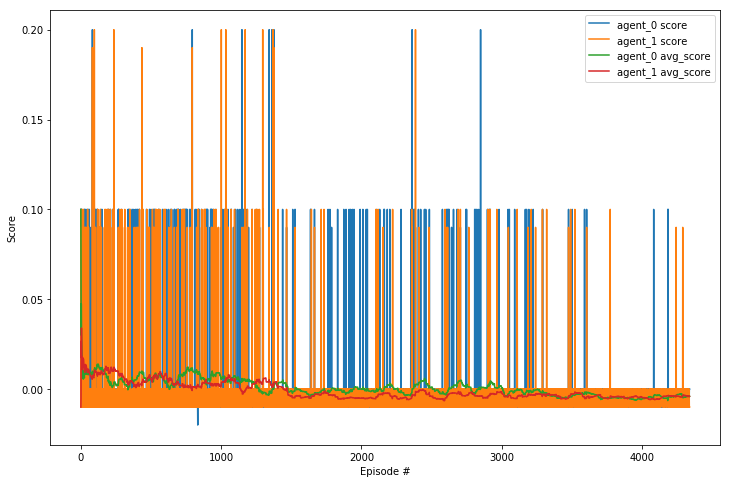

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax_0 = fig.add_subplot(111)
for agent_num in range(2):
    plt.plot(np.arange(1, len(agent_scores[agent_num])+1), agent_scores[agent_num], label=['agent_0 score','agent_1 score'][agent_num])
for agent_num in range(2):
    agent_score_avg = [np.mean(agent_scores[agent_num][max(0,i-100+1):(i+1)]) for i in range(len(agent_scores[agent_num]))]
    plt.plot(np.arange(1, len(agent_score_avg)+1), agent_score_avg, label=['agent_0 avg_score','agent_1 avg_score'][agent_num])

    
    
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper right')
plt.show()

In [8]:
obs, obs_full, action, reward, next_obs, next_obs_full, done = map(transpose_to_tensor, samples) # get data

In [11]:
obs[0].shape

torch.Size([256, 24])

In [21]:
obs[0].t()

tensor([[-5.0446e+00, -5.4955e-01, -8.4455e-01,  ..., -4.2702e-01,
          0.0000e+00, -2.9586e+00],
        [-1.5589e+00, -1.8522e+00, -1.8522e+00,  ..., -1.8522e+00,
          0.0000e+00, -1.7158e+00],
        [ 2.1895e+01,  2.2523e+01,  7.7726e+00,  ...,  2.8649e+01,
          0.0000e+00,  2.7427e+01],
        ...,
        [ 5.1760e+00,  1.5742e+00, -1.1846e+00,  ...,  2.2879e+00,
          5.9176e+00,  4.7247e+00],
        [ 1.3903e+01,  1.4668e+01,  9.8909e+00,  ...,  2.7538e+01,
          2.9369e+01,  1.8255e+01],
        [ 0.0000e+00, -4.7684e-06, -4.7684e-06,  ..., -4.7684e-06,
         -9.8100e-01,  0.0000e+00]])

In [14]:
len(obs_full)

48

In [54]:
obs_full = torch.cat(obs, 1).t()

In [49]:
torch.stack(obs, dim=-1).shape

torch.Size([256, 24, 2])

In [39]:
??torch.stack

In [55]:
print(obs_full[0,0]);print(obs_full[20,50]);
print(obs_full[35,100]);print(obs_full[47,20])

tensor(-5.0446)
tensor(-6.0970)
tensor(2.0950)
tensor(2.4874)


In [30]:
print(torch.stack(obs_full)[0,0]);print(torch.stack(obs_full)[20,50]);
print(torch.stack(obs_full)[35,100]);print(torch.stack(obs_full)[47,20])

tensor(-5.0446)
tensor(-6.0970)
tensor(2.0950)
tensor(2.4874)


In [25]:
torch.stack(obs_full).shape

torch.Size([48, 256])

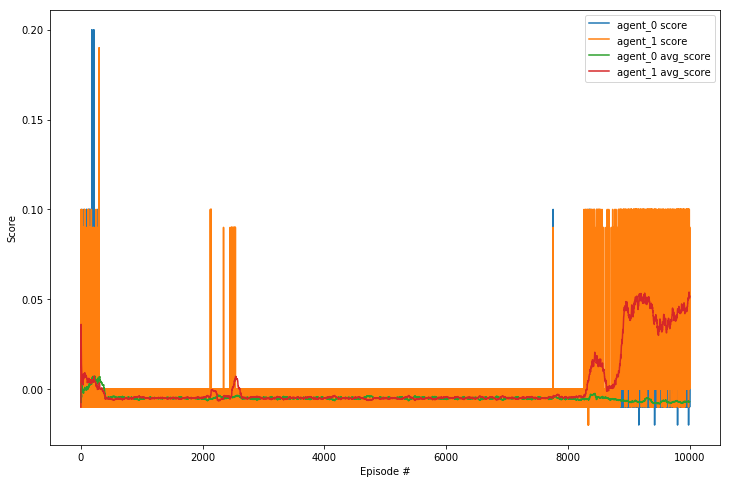

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax_0 = fig.add_subplot(111)
for agent_num in range(2):
    plt.plot(np.arange(1, len(agent_scores[agent_num])+1), agent_scores[agent_num], label=['agent_0 score','agent_1 score'][agent_num])
for agent_num in range(2):
    agent_score_avg = [np.mean(agent_scores[agent_num][max(0,i-100+1):(i+1)]) for i in range(len(agent_scores[agent_num]))]
    plt.plot(np.arange(1, len(agent_score_avg)+1), agent_score_avg, label=['agent_0 avg_score','agent_1 avg_score'][agent_num])

    
    
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper right')
plt.show()

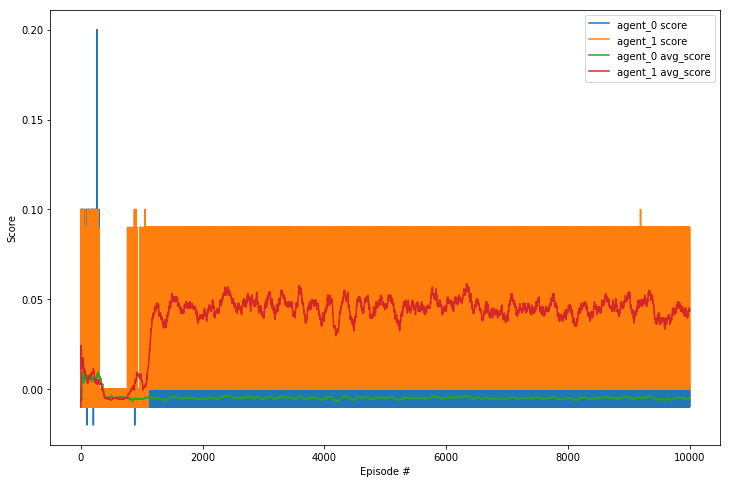

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax_0 = fig.add_subplot(111)
for agent_num in range(2):
    plt.plot(np.arange(1, len(agent_scores[agent_num])+1), agent_scores[agent_num], label=['agent_0 score','agent_1 score'][agent_num])
for agent_num in range(2):
    agent_score_avg = [np.mean(agent_scores[agent_num][max(0,i-100+1):(i+1)]) for i in range(len(agent_scores[agent_num]))]
    plt.plot(np.arange(1, len(agent_score_avg)+1), agent_score_avg, label=['agent_0 avg_score','agent_1 avg_score'][agent_num])

    
    
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper right')
plt.show()

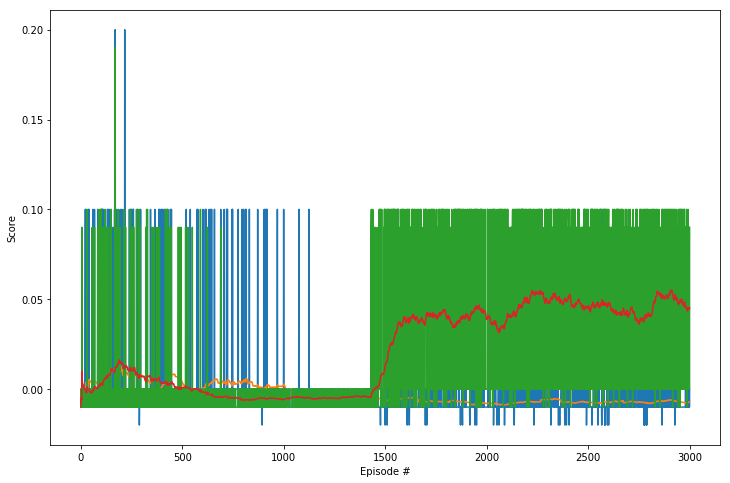

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax_0 = fig.add_subplot(111)
for agent_num in range(2):
    
    plt.plot(np.arange(1, len(agent_scores[agent_num])+1), agent_scores[agent_num])

    agent_score_avg = [np.mean(agent_scores[agent_num][max(0,i-100+1):(i+1)]) for i in range(len(agent_scores[agent_num]))]
    plt.plot(np.arange(1, len(agent_score_avg)+1), agent_score_avg)

plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

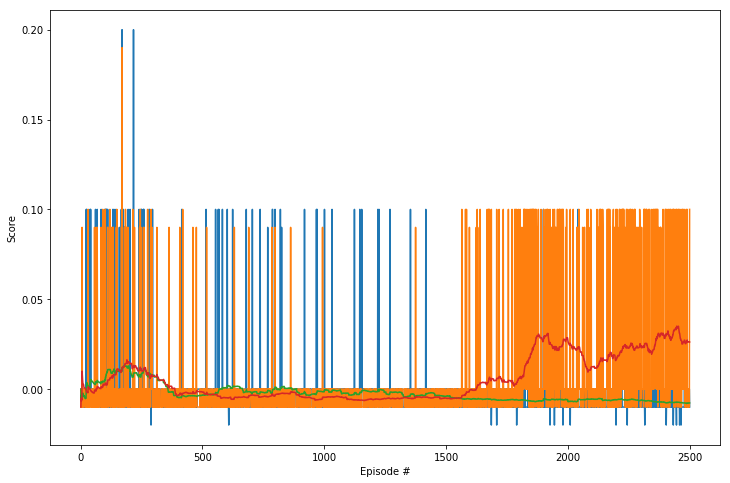

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax_0 = fig.add_subplot(111)
plt.plot(np.arange(1, len(agent0_score)+1), agent0_score)
plt.plot(np.arange(1, len(agent1_score)+1), agent1_score)

agent0_score_avg = [np.mean(agent0_score[max(0,i-100+1):(i+1)]) for i in range(len(agent0_score))]
agent1_score_avg = [np.mean(agent1_score[max(0,i-100+1):(i+1)]) for i in range(len(agent1_score))]

plt.plot(np.arange(1, len(agent0_score_avg)+1), agent0_score_avg)
plt.plot(np.arange(1, len(agent1_score_avg)+1), agent1_score_avg)

plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [10]:
env.close()

In [8]:
0.00025

0.00025

In [7]:
1.0e-4

0.0001

In [9]:
0.0005

0.0005

In [ ]:
lr_actor=1.0e-2, lr_critic=1.0e-4

In [ ]:
The sweet spot is around 0.00025 for the actor, and 0.0005 for the critic

In [ ]:
env.close()

In [ ]:
cd MADDPG\workspace

tensorboard --logdir log